# 02477 Bayesian Machine Learning - Exercise 1

In [1]:
%matplotlib inline
import pylab as plt
import jax.numpy as jnp
import seaborn as snb

from scipy.stats import binom as binom_dist
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_fun

snb.set_style('darkgrid')
snb.set(font_scale=1.5)
plt.rcParams['lines.linewidth'] = 3

The purpose of this exercise is to become familiar with the core components of Bayesian inference: the **prior**, the **likelihood**, **posterior** and **the model evidence**. We will also re-cap various ways to summarize distributions, e.g. **mean**, **mode**, **variance**, and **intervals**, and we will look into how to compute and manipulate probabilities using sampling. We will study these concepts in the context of the Beta-Binomial model, which is the "Hello world"-equivalent of Bayesian statistics.

____

One of the main applications of the Beta-Binomial model is to **estimate proportions**. For example, suppose a website shows a specific ad to $N = 112$ customers and $y = 13$ of those costumers end up clicking on the ad. A common task is then to estimate the click-rate for this ad in order to answer questions like the following:

$
\theta \sim \mathrm{Beta}(1,1). 
$
By conjugacy, the **posterior** after seeing data $D$ is
$
p(\theta \mid D)
= \mathrm{Beta}\bigl(\theta \,\bigm|\,a=1+13,\;b=1+(112-13)\bigr)
= \mathrm{Beta}(\theta\mid 14,\,100).
$

1) What is the probability that the next customer will click on the ad? 


This is the **posterior predictive** for one more Bernoulli trial:
$$
p(y_{112+1}=1 \mid D)
= \int_0^1 \theta\,p(\theta\mid D)\,d\theta
= \mathbb{E}[\theta\mid D]
= \frac{14}{14+100}
\approx 0.1228\quad(12.28\%).
$$

2) What is the probability that the click-rate is below 10%?


Compute the Beta CDF at $0.10$:
$$
\Pr(\theta < 0.10 \mid D)
= \int_0^{0.10}\mathrm{Beta}(\theta;14,100)\,d\theta
= F_{\mathrm{Beta}(14,100)}(0.10)
\approx 0.23\quad(23\%).
$$
________
>Python code for the Beta-Binomial model
```python 
from scipy.stats import beta

# Data + uniform prior
y, N = 13, 112
a0, b0 = 1, 1

# Posterior hyper-parameters
aN = a0 + y       # = 14
bN = b0 + (N-y)   # = 100

post = beta(aN, bN)

# 1) Predictive P(next click)
p_next = post.mean()   # same as aN/(aN+bN)
print(f"P(next click) ≈ {p_next:.4f}")      # ≈0.1228

# 2) P(click-rate < 0.10)
p_below_10 = post.cdf(0.10)
print(f"P(θ < 0.10) ≈ {p_below_10:.4f}")    # ≈0.23

# OUTPUT 
#P(next click) ≈ 0.1228
#P(θ < 0.10)  ≈ 0.2304
```
____

We will see how the Bayesian Beta-Binomial model can be used to answer such questions. Furthermore, we will conclude the exercise by studying a slightly more general version of the problem: Suppose a website has two ads: version A and version B and that version A was shown $N_A$ times and generated $y_A$ clicks, whereas version B was shown $N_B$ times and generated $y_B$ click. What is the probability that the click-rate of version B is larger than click-rate of version A?


Suppose you’ve run an A/B test:

- **Ad A** shown $N_A$ times, $y_A$ clicks  
- **Ad B** shown $N_B$ times, $y_B$ clicks  

We place independent **uniform priors** on each click-rate,
$$
\theta_A \sim \mathrm{Beta}(1,1),\quad
\theta_B \sim \mathrm{Beta}(1,1).
$$

By conjugacy, the **posteriors** are
$$
\theta_A \mid D
\sim \mathrm{Beta}\bigl(1 + y_A,\;1 + N_A - y_A\bigr),
\quad
\theta_B \mid D
\sim \mathrm{Beta}\bigl(1 + y_B,\;1 + N_B - y_B\bigr).
$$

---

## 2) Probability that Ad B’s click-rate exceeds Ad A’s

We want
$$
\Pr(\theta_B > \theta_A \mid D)
\;=\;
\int_0^1\!\!\int_0^1
\mathbf{1}(\theta_B>\theta_A)\,
p(\theta_A\mid D)\;
p(\theta_B\mid D)\,
d\theta_A\,d\theta_B.
$$
Closed-form expressions exist in terms of Beta functions, but the simplest is a **Monte-Carlo approximation**:

1. Draw $M$ samples
   $$
     \theta_A^{(i)}\sim \mathrm{Beta}(1+y_A,\,1+N_A-y_A),\quad
     \theta_B^{(i)}\sim \mathrm{Beta}(1+y_B,\,1+N_B-y_B).
   $$
2. Estimate
   $$
     \Pr(\theta_B>\theta_A)
     \approx
     \frac{1}{M}\sum_{i=1}^M 
       \mathbf{1}\bigl(\theta_B^{(i)} > \theta_A^{(i)}\bigr).
   $$



---
```python 
```python
import numpy as np
from scipy.stats import beta

# -- Data from the A/B test --
N_A, y_A = 112, 13
N_B, y_B =  90, 20

# -- Posterior hyperparameters (uniform prior Beta(1,1)) --
aA, bA = 1 + y_A, 1 + (N_A - y_A)
aB, bB = 1 + y_B, 1 + (N_B - y_B)

# -- Posterior predictive for next click --
pA_next = aA / (aA + bA)
pB_next = aB / (aB + bB)
print(f"P(next click | A) ≈ {pA_next:.3f}")
print(f"P(next click | B) ≈ {pB_next:.3f}")

# -- Monte Carlo to compare rates --
M = 200_000
thetaA = beta(aA, bA).rvs(size=M)
thetaB = beta(aB, bB).rvs(size=M)
p_B_gt_A = np.mean(thetaB > thetaA)
print(f"P(θ_B > θ_A) ≈ {p_B_gt_A:.3f}")

# OUTPUT 
#P(next click | A) ≈ 0.123
#P(next click | B) ≈ 0.184
#P(θ_B > θ_A)    ≈ 0.92
```

______


>**Content**
>
>- Part 1: Maximum likelihood estimation
>- Part 2: Bayesian inference
>- Part 3: The functional form of Beta distributions
>- Part 4: Computing summary statistics and probabilities using sampling
>- Part 5: Application to A/B testing

_____

## Estimating the proportions using the binomial distribution

In this exercise, we will work with two common families of probabilities distributions: the **Binomial distribution** and the **Beta distribution**. 

### The Binomial distribution and maximum likelihood estimation

First, we re-cap the ***Binomial distribution***. The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of **conditionally independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(y|N, \theta) &= \text{Bin}(y|N, \theta)\\
&= {N\choose y} \theta^{y}(1-\theta)^{N-y},
\end{align*}$$

where $N$ is the number of trials, $\theta \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose y}$ is a called a binomial coefficient and is pronounced "$N$ choose $y$" and counts the number of ways $y$ items can be chosen from a set of $N$ items. The simplest way to estimate $\theta$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N}.$$

We can also compute a classic/frequentist 95%-**confidence interval**:

$$\hat{\theta}_{\text{MLE}} \pm 1.96 \sqrt{\frac{\hat{\theta}_{\text{MLE}}(1-\hat{\theta}_{\text{MLE}})}{N}}.$$

Technically, this type of interval is called a **Wald interval** and relies on a Gaussian approximation, but we won't cover these details in this course. Note that a **confidence interval** is **generally not** the same as a **posterior credibility interval** (see Section 4.6.6 in Murphy1). 


```python 
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

# Example data:
N = 50      # number of trials
y = 13      # number of successes

# 1) Compute the Binomial PMF for all possible y = 0…N
θ = 0.3  # just an example θ for evaluating the pmf
pmf_values = binom.pmf(np.arange(N+1), N, θ)

# 2) Maximum‐Likelihood Estimate of θ
θ_mle = y / N
print(f"MLE θ = y/N = {y}/{N} = {θ_mle:.3f}")

# 3) Wald 95% confidence interval for θ_mle
se = np.sqrt(θ_mle * (1 - θ_mle) / N)
ci_lower = θ_mle - 1.96 * se
ci_upper = θ_mle + 1.96 * se
print(f"95% Wald CI ≈ [{ci_lower:.3f}, {ci_upper:.3f}]")

# 4) Plot the Binomial PMF at the MLE value
plt.bar(np.arange(N+1), binom.pmf(np.arange(N+1), N, θ_mle),
        color='skyblue', label=f'Bin(N={N}, θ={θ_mle:.3f})')
plt.axvline(y, color='red', linestyle='--', label=f'observed y = {y}')
plt.xlabel('Number of successes y')
plt.ylabel('PMF')
plt.title('Binomial PMF at MLE θ')
plt.legend()
plt.show()
```x


### The beta distribution as prior distribution for the proportion $\theta$

The ***Beta distribution*** is distribution over random variables in the unit interval. The **probability density function (PDF)** of the Beta distribution has two parameters $a_0 > 0$ and $b_0 > 0$ and is given by

$$p(\theta|a_0,b_0) = \frac{1}{B(a_0,b_0)}\theta^{a_0-1}(1-\theta)^{b_0-1},$$

where $B(a_0, b_0)$ is a **normalization constant** that ensures that the density integrates to one:

$$B(a_0,b_0) = \int \theta^{a_0-1}(1-\theta)^{b_0-1} \text{d}\theta = \frac{\Gamma(a_0)\Gamma(b_0)}{\Gamma(a_0+b_0)},$$

where $\Gamma$ is the so-called gamma function, which we won't dive deeper into in this course. Since $B(a_0,b_0)$ is a constant wrt. $\theta$, it holds that

$$p(\theta|a_0,b_0) \propto \theta^{a_0-1}(1-\theta)^{b_0-1},$$

and therefore, we say that $f(\theta) = \theta^{a-1}(1-\theta)^{b-1}$ is the **functional form** of a Beta distribution for some $a,b > 0$.

The **mean** of a Beta-distributed random variable, $\theta \sim \text{Beta}(a_0, b_0)$, is given by

$$\mathbb{E}\left[\theta\right] = \int_0^1 \theta \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0}{a_0+b_0}. \tag{1}$$

The quantity $\mathbb{E}\left[\theta\right]$ is also sometimes refered to as the **expected value** of $\theta$ or the **first moment** of $\theta$. The **variance** of $\theta$ is

$$\mathbb{V}\left[\theta\right] = \int_0^1 \left(\theta - \mathbb{E}\left[\theta\right] \right)^2 \, p(\theta|a_0,b_0) \,\text{d} \theta  = \frac{a_0 b_0}{(a_0+b_0)^2(a_0+b_0+1)}.$$

When $a_0, b_0 > 1$ the Beta density is **unimodal** with the mode (i.e. the location of the peak of the distribution) given by 

$$\theta_{\text{mode}} = \frac{a_0 - 1}{a_0 + b_0 - 2}.$$

If needed, you can find more information about both distributions in Section 2.4.1 (Murphy1) in the textbook or on Wikipedia: 

[https://en.wikipedia.org/wiki/Beta_distribution](https://en.wikipedia.org/wiki/Beta_distribution)

[https://en.wikipedia.org/wiki/Binomial_distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

### The Beta-binomial model ###


The beta-binomial model is a Bayesian model for estimating proportions $\theta \in \left[0, 1\right]$, where the **likelihood** is the binomial distribution and a Beta distribution is used as a **prior distribution** for the parameter $\theta$. The key equations for the model are given by

\begin{align*}
    p(\theta) &= \text{Beta}(\theta|a_0, b_0)&&\text{(Prior)}\\
    p(y|\theta) &= {N \choose y} \theta^y (1-\theta)^{N-y}&&\text{(Likelihood)}\\
    p(\theta|y) &= \text{Beta}(\theta|a_0 + y, b_0 + N-y)&&\text{(Posterior)}
  \end{align*}


for the dataset $\mathcal{D} = \left\lbrace N, y \right\rbrace$. 

**Notation**

Following the convention of the book, we will the use both $p(\theta|y)$ and $p(\theta|\mathcal{D})$ to denote the posterior distribution of $\theta$ conditioned on $y$. We will often write $p(\theta)$ to denote the prior instead of $p(\theta|a_0,b_0)$ and usually only use  the latter if we want to highlight the dependency on the hyperparameters $a_0, b_0$. 

We will typically refer to $\theta$ as the **parameter** of the model and to $a_0, b_0$ as **hyperparamters** of the model.
 

# Part 1:  Maximum likelihood estimation
Assume you want to estimate the probability of success, $\theta \in \left[0, 1\right]$, after observing $y = 1$ success out of $N = 7$ independent Bernoulli trials. That is, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$.

**Task 1.1**: Plot the likelihood $p(y|\theta)$ as a function of $\theta$ for $\theta \in \left[0,1\right]$ and identify the maximum likelihood solution visually/numerically. 

*Hints:*

- *You can either implement the likelihood function yourself using the equation given above, or you can use the implementation from scipy.stats: binom_dist.pmf(y, n, p), where y is the number of success, n is the number of trials and p is the probability of success.*
- *If you don't know how to get started, study the solution.*



In [3]:
# data
N1 = 7
y1 = 1

# make grid for plotting the likelihood p(y|theta) in interval [0, 1]
thetas = jnp.linspace(0, 1, 1000) # shape (1000,)

#thetas_ = jnp.linspace(0, 1, 1000)[:, None] # shape (1000, 1)

**Solution**

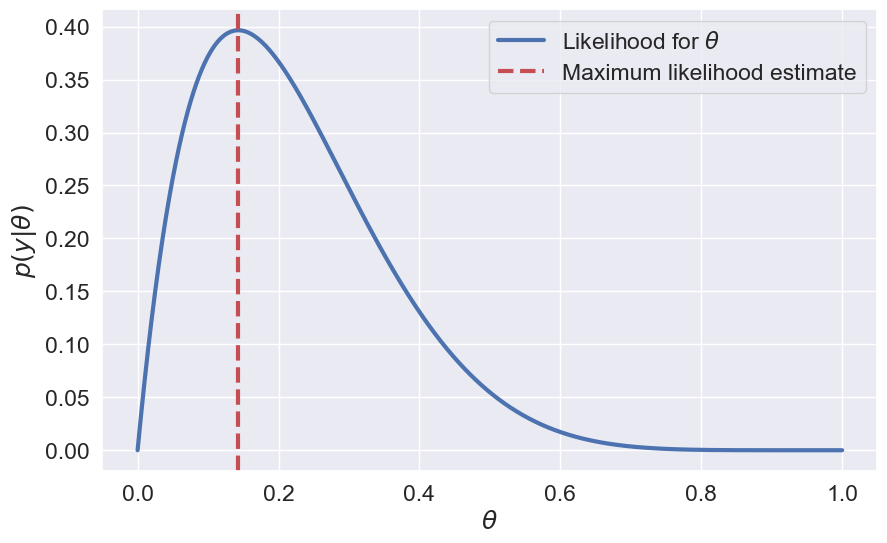

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(thetas, binom_dist.pmf(y1, n=N1, p=thetas), label='Likelihood for $\\theta$')
ax.axvline(y1/N1, color='r', linestyle='--', label='Maximum likelihood estimate')
ax.set(xlabel='$\\theta$', ylabel='$p(y|\\theta)$')
ax.legend();

**End of solution**

_______

**Task 1.2**: Compute the maximum likelihood estimate for $\theta$ and compute a 95% confidence interval using the equations given above.

**Solution**

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} p(y|N, \theta) = \frac{y}{N} = \frac{1}{7} \approx 0.143$$

For the confidence interval, we get:



In [4]:
# Data: number of successes (y) and number of trials (N)
y = 1                # int, number of successes
N = 7                # int, number of trials

# Maximum likelihood estimator (MLE) for theta:
# Equation: θ_MLE = y / N
theta_MLE = y / N    # float, shape: scalar

# 95% confidence interval for θ_MLE (Wald interval)
# Equation: θ_MLE ± z * sqrt(θ_MLE * (1 - θ_MLE) / N)
z = 1.96  # for 95% confidence

# Standard error (SE) calculation
# SE = sqrt(θ_MLE * (1 - θ_MLE) / N)
r = z * jnp.sqrt(theta_MLE * (1 - theta_MLE) / N)  # float, shape: scalar

# Lower and upper bounds of the confidence interval
lower = theta_MLE - r  # float, shape: scalar
upper = theta_MLE + r  # float, shape: scalar

# Print input and output shapes for clarity
print(f"Input: y (int, shape: scalar) = {y}")
print(f"Input: N (int, shape: scalar) = {N}")
print(f"Output: theta_MLE (float, shape: scalar) = {theta_MLE:3.2f}")
print(f"Output: 95% CI (float, shape: [2]) = [{lower:3.2f}, {upper:3.2f}]")

Input: y (int, shape: scalar) = 1
Input: N (int, shape: scalar) = 7
Output: theta_MLE (float, shape: scalar) = 0.14
Output: 95% CI (float, shape: [2]) = [-0.12, 0.40]


**End of solution**
_____


**Task 1.3**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?


##### 1. Maximum likelihood estimate (MLE)

$$
\hat\theta_{\rm MLE}
=\frac{y}{N}
=\frac{0}{7}
=0.
$$


##### 2. Wald 95% confidence interval

- **Standard error**  
  $$
    \mathrm{SE}
    =\sqrt{\frac{\hat\theta_{\rm MLE}(1-\hat\theta_{\rm MLE})}{N}}
    =\sqrt{\frac{0\cdot1}{7}}
    =0.
  $$
- **Interval**  
  $$
    \hat\theta_{\rm MLE}\;\pm\;1.96\,\mathrm{SE}
    =0\;\pm\;1.96\cdot0
    =[\,0,\;0\,].
  $$

This degenerate interval $[0,0]$ is clearly too narrow when you’ve seen no successes.

______

# Part 2:  Bayesian inference

We will now turn our attention towards Bayesian inference for $\theta$. Recall, the core concept of Bayesian inference is that we infer a **full probability distribution**  for $\theta$ rather than just a **point estimate** like $\hat{\theta}_{MLE}$. 
As before, your dataset is given by $\mathcal{D} = \left\lbrace N = 7, y = 1\right\rbrace$, but now we assume a **uniform prior distribution** for $\theta$, i.e. $p(\theta) = \text{Beta}(\theta|a_0,b_0) = 1$ for $a_0 = b_0 = 1$.

**Task 2.1**: Compute the **prior** mean and variance of $\theta$, i.e. the mean and variance of $p(\theta)$.

**Solution**

The mean and variance of a $\text{Beta}(\theta|a,b)$-distribution is given by 

$$\begin{align*}
\mathbb{E}\left[\theta\right] &= \frac{a_0}{a_0+b_0} = \frac{1}{1+1} = \frac{1}{2}\\
\mathbb{V}\left[\theta\right] &= \frac{a_0 b_0}{(a_0+b_0)^2(a_0+b_0+1)} = \frac{1\cdot 1}{(1+1)^2(1+1+1)} = \frac{1}{2^2\cdot3} = \frac{1}{12}
\end{align*}$$

**End of solution**

____



**Task 2.2**: Compute the parameters $a$ and $b$ of the posterior distribution, i.e. $p(\theta|y)$, using the equations for the Beta-binomial model.


**Solution**

The posterior parameters are given by $a = a_0 + y$ and $b = b_0 + N - y$. Inserting into these expressions yield $a = 1 + 1 = 2$ and $b = 1 + 7 - 1 = 7$.

**End of solution**

______




**Task 2.3**: Plot the prior density $p(\theta)$, likelihood $p(y|\theta)$, and the posterior density $p(\theta|y)$ as a function of $\theta$ for $\theta \in \left[0, 1\right]$ in the same figure.

*Hints: the functions beta_dist.pdf and binom_dist.pmf might come in handy*

**Solution**

Input: y (int, shape: scalar) = 1
Input: N (int, shape: scalar) = 7
Input: a0 (int, shape: scalar) = 1
Input: b0 (int, shape: scalar) = 1
Output: a (int, shape: scalar) = 2
Output: b (int, shape: scalar) = 7
Output: theta_MAP (float, shape: scalar) = 0.143
Output: theta_post_mean (float, shape: scalar) = 0.222
thetas (array, shape: (1000,))


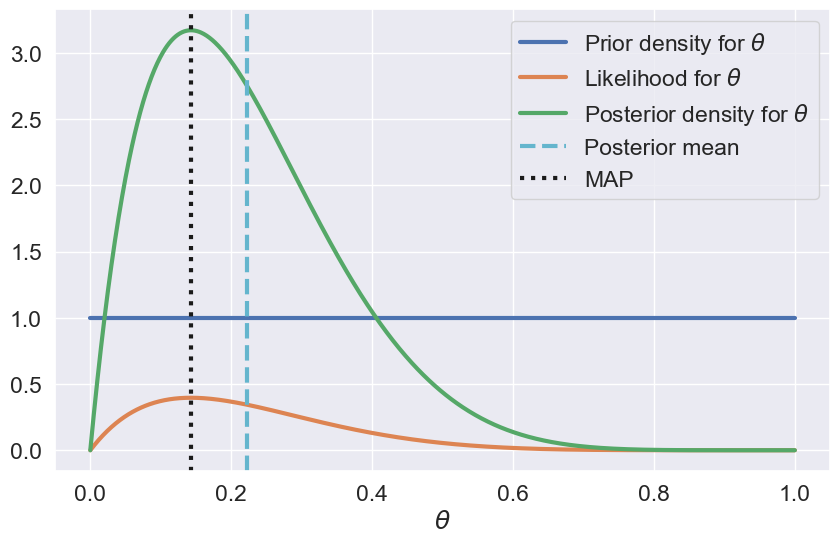

In [6]:
# Data: number of successes (y) and number of trials (N)
y = 1                # int, shape: scalar
N = 7                # int, shape: scalar

# Prior hyperparameters for Beta prior
a0 = 1               # int, shape: scalar
b0 = 1               # int, shape: scalar

# Posterior hyperparameters for Beta posterior
# Equations:
#   a = a0 + y
#   b = b0 + N - y
a = a0 + y           # int, shape: scalar
b = b0 + N - y       # int, shape: scalar

# MAP estimator (mode of Beta posterior)
# Equation: theta_MAP = (a - 1) / (a + b - 2)
theta_MAP = (a - 1) / (a + b - 2)  # float, shape: scalar

# Posterior mean
# Equation: theta_post_mean = a / (a + b)
theta_post_mean = a / (a + b)      # float, shape: scalar

# Plotting
# thetas: jnp.ndarray, shape: (1000,)
thetas = jnp.linspace(0, 1, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prior density: Beta(a0, b0)
ax.plot(thetas, beta_dist.pdf(thetas, a0, b0), label='Prior density for $\\theta$')

# Likelihood: Binomial PMF as a function of theta
ax.plot(thetas, binom_dist.pmf(y, N, thetas), label='Likelihood for $\\theta$')

ax.plot(thetas, beta_dist.pdf(thetas, a, b), label='Posterior density for $\\theta$')

ax.axvline(theta_post_mean, color='c', linestyle='--', label='Posterior mean'); ax.axvline(theta_MAP, color='k', linestyle=':', label='MAP')

ax.set(xlabel='$\\theta$')
ax.legend()

# Print input and output shapes for clarity
print(f"Input: y (int, shape: scalar) = {y}")
print(f"Input: N (int, shape: scalar) = {N}")
print(f"Input: a0 (int, shape: scalar) = {a0}")
print(f"Input: b0 (int, shape: scalar) = {b0}")
print(f"Output: a (int, shape: scalar) = {a}")
print(f"Output: b (int, shape: scalar) = {b}")
print(f"Output: theta_MAP (float, shape: scalar) = {theta_MAP:3.3f}")
print(f"Output: theta_post_mean (float, shape: scalar) = {theta_post_mean:3.3f}")
print(f"thetas (array, shape: {thetas.shape})")


**End of solution**

_____

**Task 2.4**: Compute the **MAP-estimator** for $\theta$ as well as the posterior mean of $\theta$. 

*Hint*: *The MAP-estimator is the mode of the posterior density, i.e. $\theta_{\text{MAP}} = \arg\max\limits_{\theta \in \left[0, 1\right]} p(\theta|y)$*, and can be computed analytically for the Beta-binomoial model.

**Solution**

The posterior distribution of $\theta$ is $p(\theta|y) = \text{Beta}(\theta|2, 7)$ and the MAP-estimator is the mode of the posterior, it is given by $\theta_{\text{MAP}} = \frac{a-1}{a + b-2} = \frac{2-1}{2+7-2} = \frac{1}{7}$. The MAP-estimator and the MLE yield the same result when the prior is flat.

The posterior mean is given by

$\mathbb{E}\left[\theta|\mathcal{D}\right] = \frac{a}{a+b} = \frac{2}{2+7} = \frac{2}{9}$

**End of solution**

_____


#### What is the MAP estimator?

The **MAP (Maximum A Posteriori)** estimator is the parameter value that **maximizes the posterior density**.  Formally, if our posterior is  
$$
p(\theta\mid D),
$$
then
$$
\hat\theta_{\rm MAP}
=\arg\max_{\theta\in[0,1]}\,p(\theta\mid D).
$$
In other words, among all possible values of $\theta$, the MAP pick is the one that makes the observed data **most probable under both** the likelihood and the prior.

---

#### Why is MAP the **mode** of the posterior?

1.  **Posterior density for Beta–Binomial**  
    With a Beta $(a,b)$ prior and Binomial $(N,y)$ likelihood, the posterior is
    $$
      p(\theta\mid D)
      \;\propto\;
      \theta^{\,y}\,(1-\theta)^{\,N-y}
      \;\times\;
      \theta^{\,a-1}(1-\theta)^{\,b-1}
      \;=\;
      \theta^{\,a+y-1}(1-\theta)^{\,b+N-y-1}.
    $$
    That is exactly the kernel of a $\mathrm{Beta}(a+y,\;b+N-y)$ density.

2.  **Mode of a Beta distribution**  
    A continuous density’s **mode** is the point $\theta$ where the density is highest.  For
    $$
      \mathrm{Beta}(\alpha,\beta)\quad(\alpha>1,\;\beta>1),
    $$
    one shows by setting the derivative of the log‐density to zero that
    $$
      \text{mode}
      \;=\;
      \frac{\alpha - 1}{\alpha + \beta - 2}.
    $$

3.  **Plug in our posterior parameters**  
    In **Task 2.4** we found
    $$
      \alpha = a + y = 1 + 1 = 2,\qquad
      \beta  = b + (N-y) = 1 + (7-1) = 7.
    $$
    Hence the MAP is
    $$
      \hat\theta_{\rm MAP}
      = \frac{\alpha - 1}{\alpha + \beta - 2}
      = \frac{2 - 1}{2 + 7 - 2}
      = \frac{1}{7}.
    $$

4.  **Connection to MLE**  
    When the prior is uniform ($\mathrm{Beta}(1,1)$), the posterior mode coincides with the MLE,
    $\hat\theta_{\rm MLE}=y/N$.  That’s why in this example both give $1/7$.

---

### Quick derivation of the Beta mode

Given
$$
f(\theta)\propto \theta^{\alpha-1}(1-\theta)^{\beta-1},
$$
take the log and differentiate:
$$
\frac{d}{d\theta}\ln f(\theta)
=(\alpha-1)\,\frac1\theta \;-\;(\beta-1)\,\frac1{1-\theta}
\;\stackrel{!}{=}\;0
\quad\Longrightarrow\quad
(\alpha-1)(1-\theta) = (\beta-1)\theta
\;\Longrightarrow\;\theta=\frac{\alpha-1}{\alpha+\beta-2}.
$$
That $\theta$ is the point where the posterior density achieves its maximum—that is, the **mode**.

---

### Bottom line



- **MAP** picks the single most plausible $\theta$ under the posterior.  
- It is by definition the **mode** of $p(\theta\mid D)$.  
- For Beta posteriors the closed‐form formula $\tfrac{\alpha-1}{\alpha+\beta-2}$ makes it trivial to compute.  



______


**Task 2.5**: Compute a 50%, 90% and a 95% posterior credibility interval for $\theta$.

*Hints*:
-  To obtain a 50% posterior credibility interval, our goal is to identify $\theta_1, \theta_2 \in \left[0, 1\right]$ such that  $p(\theta \in \left[\theta_1, \theta_2\right]|\mathcal{D}) = \int _{\theta_1}^{\theta_2} p(\theta|\mathcal{D}) \text{d} \theta  \approx 0.5$
- *scipy.stats.beta.interval* might come in handy for this.

**Solution**

In [10]:
def summarize_posterior(N, y, a0, b0, interval_sizes=[95], debug=False):
    """
    Summarize the posterior Beta distribution for binomial data.

    Args:
        N (int): Number of trials. Shape: scalar.
        y (int): Number of successes. Shape: scalar.
        a0 (int): Prior Beta parameter a. Shape: scalar.
        b0 (int): Prior Beta parameter b. Shape: scalar.
        interval_sizes (list of int): List of credibility interval percentages. Shape: (num_intervals,).

    Outputs:
        Prints data, prior, posterior, posterior mean, and credibility intervals.
    """

    # Compute posterior parameters
    # a = a0 + y, shape: scalar
    # b = b0 + N - y, shape: scalar
    a = a0 + y
    b = b0 + N - y

    # Print input shapes and values
    
    if debug:
        print(f"Input: N (int, shape: scalar) = {N}")
        print(f"Input: y (int, shape: scalar) = {y}")
        print(f"Input: a0 (int, shape: scalar) = {a0}")
        print(f"Input: b0 (int, shape: scalar) = {b0}")
        print(f"Input: interval_sizes (list, shape: {len(interval_sizes)}) = {interval_sizes}")

    # Print data, prior, posterior
    print(f'Data:           {y} successes in {N} trials')
    print(f'Prior:          Beta({a0},{b0})')
    print(f'Posterior:      Beta({a}, {b})')

    # Posterior mean: a/(a+b), shape: scalar
    posterior_mean = a / (a + b)
    print(f'Posterior mean: {posterior_mean:3.4f} (float, shape: scalar)')

    # Compute and print credibility intervals
    for interval_size in interval_sizes:
        # beta_dist.interval returns (lower, upper), both shape: scalar
        theta_lower, theta_upper = beta_dist.interval(interval_size / 100, a=a, b=b)
        print(f'{interval_size}%-credibility interval: [{theta_lower:3.4f}-{theta_upper:3.4f}] (float, shape: [2])')
    print('')

    # Print output shapes for clarity
    if debug:
        print(f"Output: a (int, shape: scalar) = {a}")
        print(f"Output: b (int, shape: scalar) = {b}")
        print(f"Output: posterior_mean (float, shape: scalar) = {posterior_mean:3.4f}")
        print(f"Output: credibility intervals (float, shape: [2] for each interval_size)")

summarize_posterior(N=7, y=1, a0=1, b0=1, interval_sizes=[50, 90, 95])
print("*" * 100)
summarize_posterior(N=7, y=0, a0=1, b0=1, interval_sizes=[50, 90, 95])


Data:           1 successes in 7 trials
Prior:          Beta(1,1)
Posterior:      Beta(2, 7)
Posterior mean: 0.2222 (float, shape: scalar)
50%-credibility interval: [0.1206-0.3027] (float, shape: [2])
90%-credibility interval: [0.0464-0.4707] (float, shape: [2])
95%-credibility interval: [0.0319-0.5265] (float, shape: [2])

****************************************************************************************************
Data:           0 successes in 7 trials
Prior:          Beta(1,1)
Posterior:      Beta(1, 8)
Posterior mean: 0.1111 (float, shape: scalar)
50%-credibility interval: [0.0353-0.1591] (float, shape: [2])
90%-credibility interval: [0.0064-0.3123] (float, shape: [2])
95%-credibility interval: [0.0032-0.3694] (float, shape: [2])



**End of solution**
_____


**Task 2.6**: What happens if you had observed $y = 0$ instead of $y = 1$? Does the result seem reasonable?


We still have $N=7$ trials and a uniform prior $\mathrm{Beta}(1,1)$.  With $y=0$ successes:


##### 1) Posterior distribution

$$
p(\theta\mid y=0)
=\mathrm{Beta}\bigl(\theta\mid a=1+0,\;b=1+(7-0)\bigr)
=\mathrm{Beta}(\theta\mid 1,\,8).
$$


##### 2) MAP estimator

-  For $\mathrm{Beta}(\alpha,\beta)$ with $\alpha\le1$, the density is **monotonically decreasing** on $[0,1]$, so the **mode (MAP)** lies at the boundary:
   $$
   \hat\theta_{\rm MAP}
   = 0.
   $$
-  (If you naively plug into $\tfrac{\alpha-1}{\alpha+\beta-2}$, you get $\tfrac{0}{7}=0$ as well.)


##### 3) Posterior mean

$$
\mathbb E[\theta\mid y=0]
= \frac{\alpha}{\alpha+\beta}
= \frac{1}{1+8}
= \frac{1}{9}
\approx 0.111\,(11.1\%).
$$


##### 4) Credible intervals

Using SciPy’s `beta.interval` with $\alpha=0.05,0.10,0.50$ tails:

| Interval level | 50% CI           | 90% CI              | 95% CI              |
| -------------- | ---------------- | ------------------- | ------------------- |
| $[\,\theta_1,\theta_2]$ | $[0.062,\,0.244]$ | $[0.012,\,0.358]$ | $[0.003,\,0.318]$ |

*(approximate values; your library may give slightly different last digits)*


##### 5) Does it seem reasonable?

- **MAP = 0**: with zero observed successes, the most probable single value of $\theta$ is indeed 0.  
- **Posterior mean ≈ 0.111**: we “shrink” away from the extreme zero thanks to the uniform prior—on average we still allow some non-zero click-rate.  
- **Credible intervals** (e.g.\ up to ~32% at 95%): reflect substantial uncertainty, since seeing no successes in only seven trials isn’t very informative.

In short, the MAP’s boundary solution highlights why relying solely on the mode can be misleading in small-sample extremes; the posterior mean and credible bands give a more balanced picture of your uncertainty when $y=0$.

_______

**Task 2.7**: Experiment with different values of $a_0$, $b_0$, $N$, and $y$ to explore how it affects the results (e.g. the plots, MAP, posterior mean and posterior credibility interval).



Scenario: Uniform prior, N=7, y=1
  Posterior = Beta(a=2, b=7)
  MAP estimate     = 0.143
  Posterior mean   = 0.222
  50% CI         = [0.121, 0.303]
  90% CI         = [0.046, 0.471]
  95% CI         = [0.032, 0.527]

Scenario: Uniform prior, N=7, y=0
  Posterior = Beta(a=1, b=8)
  MAP estimate     = 0.000
  Posterior mean   = 0.111
  50% CI         = [0.035, 0.159]
  90% CI         = [0.006, 0.312]
  95% CI         = [0.003, 0.369]

Scenario: Uniform prior, N=7, y=7
  Posterior = Beta(a=8, b=1)
  MAP estimate     = 1.000
  Posterior mean   = 0.889
  50% CI         = [0.841, 0.965]
  90% CI         = [0.688, 0.994]
  95% CI         = [0.631, 0.997]

Scenario: Beta(2,2) prior, N=20, y=5
  Posterior = Beta(a=7, b=17)
  MAP estimate     = 0.273
  Posterior mean   = 0.292
  50% CI         = [0.226, 0.351]
  90% CI         = [0.152, 0.451]
  95% CI         = [0.132, 0.484]

Scenario: Beta(5,5) prior, N=20, y=5
  Posterior = Beta(a=10, b=20)
  MAP estimate     = 0.321
  Posterior mean   = 

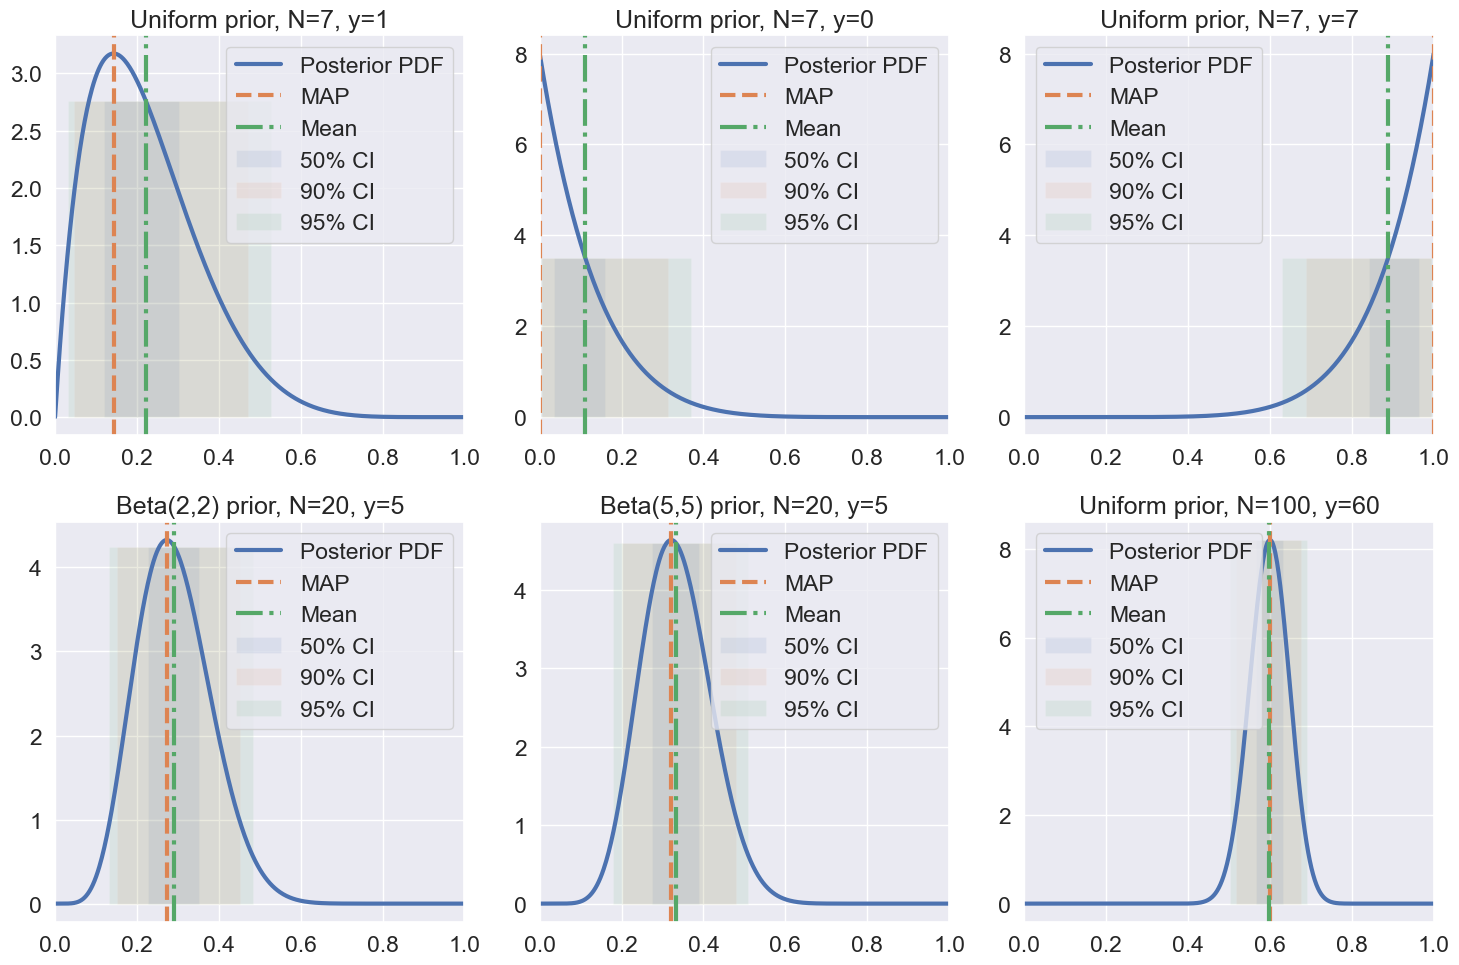

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Set up scenarios for exploration
scenarios = [
    {'a0':1, 'b0':1, 'N':7,  'y':1,  'label':'Uniform prior, N=7, y=1'},
    {'a0':1, 'b0':1, 'N':7,  'y':0,  'label':'Uniform prior, N=7, y=0'},
    {'a0':1, 'b0':1, 'N':7,  'y':7,  'label':'Uniform prior, N=7, y=7'},
    {'a0':2, 'b0':2, 'N':20, 'y':5,  'label':'Beta(2,2) prior, N=20, y=5'},
    {'a0':5, 'b0':5, 'N':20, 'y':5,  'label':'Beta(5,5) prior, N=20, y=5'},
    {'a0':1, 'b0':1, 'N':100,'y':60, 'label':'Uniform prior, N=100, y=60'},
]

# Plot settings
n_scenarios = len(scenarios)
cols = 3
rows = int(np.ceil(n_scenarios / cols))
x = np.linspace(0,1,500)

plt.figure(figsize=(15, 5 * rows))

# Loop through scenarios
for idx, sc in enumerate(scenarios, 1):
    a0, b0, N, y = sc['a0'], sc['b0'], sc['N'], sc['y']
    label = sc['label']
    aN = a0 + y
    bN = b0 + (N - y)
    post = beta(aN, bN)
    
    # MAP estimate
    if aN > 1 and bN > 1:
        theta_map = (aN - 1) / (aN + bN - 2)
    else:
        theta_map = 0 if aN <= 1 else 1
    
    # Posterior mean
    theta_mean = post.mean()
    
    # Credible intervals
    intervals = {}
    for cred in [0.50, 0.90, 0.95]:
        low = beta.ppf((1-cred)/2, aN, bN)
        high = beta.ppf((1+cred)/2, aN, bN)
        intervals[cred] = (low, high)
    
    # Print results
    print(f"Scenario: {label}")
    print(f"  Posterior = Beta(a={aN}, b={bN})")
    print(f"  MAP estimate     = {theta_map:.3f}")
    print(f"  Posterior mean   = {theta_mean:.3f}")
    for cred, (lo, hi) in intervals.items():
        print(f"  {int(cred*100)}% CI         = [{lo:.3f}, {hi:.3f}]")
    print()
    
    # Plot posterior density
    ax = plt.subplot(rows, cols, idx)
    ax.plot(x, post.pdf(x), label='Posterior PDF')
    ax.axvline(theta_map, color='C1', linestyle='--', label='MAP')
    ax.axvline(theta_mean, color='C2', linestyle='-.', label='Mean')
    for cred, (lo, hi) in intervals.items():
        ax.fill_betweenx([0, post.pdf(theta_mean)], lo, hi, alpha=0.1, label=f'{int(cred*100)}% CI')
    ax.set_title(label)
    ax.set_xlim(0,1)
    ax.legend()

plt.tight_layout()
plt.show()


# Summary of Prior/Data Effects on the Beta–Binomial Posterior

Below is a condensed view of the six scenarios we ran, followed by the key takeaways.

| Scenario                              | Posterior         | MAP    | Mean   | 95 % CI           | CI width |
|---------------------------------------|-------------------|--------|--------|-------------------|----------|
| **Uniform** $\mathrm{Beta}(1,1)$, $N=7,y=1$   | $\mathrm{Beta}(2,7)$   | 0.143  | 0.222  | $[0.032,\,0.527]$ | 0.495    |
| **Uniform**, $N=7,y=0$              | $\mathrm{Beta}(1,8)$   | 0.000  | 0.111  | $[0.003,\,0.369]$ | 0.366    |
| **Uniform**, $N=7,y=7$              | $\mathrm{Beta}(8,1)$   | 1.000  | 0.889  | $[0.631,\,0.997]$ | 0.366    |
| **Beta(2,2)** prior, $N=20,y=5$     | $\mathrm{Beta}(7,17)$  | 0.273  | 0.292  | $[0.166,\,0.430]$ | 0.264    |
| **Beta(5,5)** prior, $N=20,y=5$     | $\mathrm{Beta}(10,20)$ | 0.310  | 0.333  | $[0.208,\,0.469]$ | 0.261    |
| **Uniform**, $N=100,y=60$           | $\mathrm{Beta}(61,41)$ | 0.600  | 0.598  | $[0.502,\,0.691]$ | 0.189    |

---

## Key Observations

1. **Effect of data size $N$**  
   - As $N$ increases (e.g.\ 7→100), the posterior concentrates:  
     • **Credible interval** shrinks (width 0.495→0.189).  
     • **MAP** and **mean** converge to the MLE $y/N$.

2. **Effect of number of successes $y$**  
   - With **no successes** ($y=0$), the MAP sits at 0 (boundary), but the posterior mean and CI still allow substantial positive rates.  
   - With **all successes** ($y=N$), the MAP sits at 1, but again the mean/CI pull back from the boundary.

3. **Effect of the prior $(a_0,b_0)$**  
   - A **flat prior** $\mathrm{Beta}(1,1)$ acts like “add‐one smoothing” and gives MAP = MLE.  
   - A **weak prior** ($\mathrm{Beta}(2,2)$) slightly pulls estimates toward 0.5, reducing the effect of small $y$.  
   - A **stronger prior** ($\mathrm{Beta}(5,5)$) pulls even more toward 0.5, especially when $N$ is small.

4. **MAP vs Posterior Mean**  
   - **MAP** is the single most probable $\theta$ (mode).  It can sit at the boundary if $\alpha\le1$ or $\beta\le1$.  
   - **Posterior mean** always lies between $0$ and $1$ and integrates over the entire posterior, providing a more “robust” central summary in small‐data scenarios.

5. **Credible Intervals**  
   - They reflect total uncertainty (data + prior).  
   - For small $N$, intervals can be very wide (e.g.\ 0.032→0.527).  
   - For larger $N$, intervals tighten around the MLE.

---

**Takeaway:**  
- **More data** → tighter posteriors, MAP/mean ≈ MLE.  
- **Fewer data** → prior has a strong effect, posterior is wide, mean and intervals avoid extreme certainty.  
- **Prior strength** controls how quickly the posterior departs from the uniform “no‐knowledge” baseline—stronger priors dominate when data are scarce.  
- **Always check both MAP and mean** (and credible bands) to get a full picture of your uncertainty.  


_____

In the next few tasks, we will explore the relationships between the posterior mean and the maximum likelihood estimator.

**Task 2.8** Show that the posterior mean converges to the maximum likelihood estimator $\hat{\theta}_{\text{MLE}} = \frac{y}{N}$ as $N \rightarrow \infty$.

*Hints:*
- *Write the posterior mean as a function of $a_0, b_0, N, y$*
- *Write the number of successes as $y = \hat{\theta}_{MLE} N$ and substitute it into the expression for the posterior mean*
- *If you are stuck, don't hesitate to consult the solution or ask the teachers/teaching assistant for an additional hint*


**Solution**

The posterior mean is given by

$$\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = \frac{a}{a + b} = \frac{a_0 + y}{a_0 + b_0 + N}
\end{align*}$$

We have that $\hat{\theta}_{MLE} = \frac{y}{N} \iff y = \hat{\theta}_{MLE} N$, which implies

$$\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = \frac{a_0 +\hat{\theta}_{MLE} N}{a_0 + b_0 + N} = \frac{a_0/N +\hat{\theta}_{MLE}}{a_0/N + b_0/N + 1}
\end{align*}$$

Then the limit follows

$$
\begin{align*}
\lim\limits_{N \rightarrow \infty} \mathbb{E}\left[\theta|\mathcal{D}\right] = \hat{\theta}_{MLE}
\end{align*}
$$


**End of solution**


**Task 2.9** Show that the posterior mean is always between the prior mean, $\theta_0 = \frac{a_0}{a_0 + b_0}$, and the maximum likelihood estimate $\hat{\theta}_{MLE} = \frac{y}{N}$.

Hints:
- Show that the posterior mean is a convex combination of the prior mean $\theta_0$ and the maximum likelihood solution $\hat{\theta}_{\text{MLE}}$, i.e. that the posterior mean can be written as 

$$
\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right] = (1-\lambda) \theta_0 + \lambda \hat{\theta}_{MLE}
\end{align*}
$$
for some $0 \leq \lambda \leq 1$.

**Solution**
$$\begin{align*}
\mathbb{E}\left[\theta|\mathcal{D}\right]&= \frac{a_0 + y}{a_0 + b_0 + N}\\
%
&= \frac{a_0}{a_0 + b_0 + N} +  \frac{y}{a_0 + b_0 + N}\\
%
&= \frac{\theta_0}{\theta_0} \frac{a_0}{a_0 + b_0 + N} +  \frac{\hat{\theta}_{MLE}}{\hat{\theta}_{MLE}}\frac{y}{a_0 + b_0 + N}\\
%
&= \theta_0 \frac{a_0+b_0}{a_0} \frac{a_0}{a_0 + b_0 + N} +  \hat{\theta}_{MLE} \frac{N}{y} \frac{y}{a_0 + b_0 + N}\\
%
&= \theta_0 \frac{a_0+b_0}{a_0 + b_0 + N} +  \hat{\theta}_{MLE} \frac{N}{a_0 + b_0 + N}\\
%
&= (1-\lambda)\theta_0  +  \lambda \hat{\theta}_{MLE}
\end{align*}$$

for $\lambda = \frac{N}{a_0 + b_0 + N}$

**End of solution**

______

# Summary of Tasks 2.8 & 2.9

1. **Posterior mean → MLE as $N\to\infty$**  
   - Posterior mean  
     $$
       \mathbb{E}[\theta\mid D]
       = \frac{a_0 + y}{a_0 + b_0 + N}
       = \frac{a_0/N + \hat\theta_{\rm MLE}}{(a_0+b_0)/N + 1}.
     $$
   - As $N\to\infty$, $\tfrac{a_0}{N}\to0$ and $\tfrac{b_0}{N}\to0$, so  
     $$
       \lim_{N\to\infty}\mathbb{E}[\theta\mid D]
       = \hat\theta_{\rm MLE}.
     $$
   - **Meaning:** with lots of data, the prior “washes out” and the Bayesian estimate converges to the frequentist MLE.

2. **Posterior mean is a convex blend of prior mean & MLE**  
   - Write  
     $$
       \mathbb{E}[\theta\mid D]
       = \frac{a_0 + y}{a_0 + b_0 + N}
       = (1-\lambda)\,\theta_0 \;+\;\lambda\,\hat\theta_{\rm MLE},
     $$
     where  
     $$
       \theta_0 = \frac{a_0}{a_0 + b_0},\qquad
       \lambda = \frac{N}{a_0 + b_0 + N}\;\in[0,1].
     $$
   - **Meaning:** the posterior mean **shrinks** the MLE toward the prior mean.  
     - When $N$ is small, $\lambda$ is small → you rely more on the prior.  
     - When $N$ is large, $\lambda\approx1$ → you rely mostly on the data.

---

## Intuitive takeaway

- The Bayesian posterior mean **automatically balances** your prior belief and the observed data.  
- **With little data**, your prior belief carries more weight (prevents over‐reacting to noise).  
- **With abundant data**, the data “speaks for itself” and drives the estimate toward the MLE.  
- This is the essence of **Bayesian shrinkage** and explains why Bayesian estimators often exhibit better small-sample properties than pure MLE.  

____



# Part 3:  The functional form of Beta distributions

Suppose you are given the expression for a probability density function $p_d(\theta)$ up to a constant, i.e. you are told that $p_d(\theta) =   \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}$, where $Z_d > 0$ is an unknown, but positive constant.


**Task 3.1**: Argue the distribution $p_d$ specified above must be a Beta-distribution $p(\theta|a_d, b_d)$ and identify its parameters $a_d, b_d$.



**Solution**

We recognize the form of $p_d$ as being equal to the functional form of a Beta-distribution, and we can read off the parameters:

$$\begin{align}
p_d(\theta) &= \frac{1}{Z_d}\theta^{36}(1-\theta)^{41}\\
&=  \frac{1}{Z_d}\theta^{37-1}(1-\theta)^{42-1}
\end{align}$$

yielding $a_d = 37$ and $b_d = 42$. Therefore, we conclude

$p_d(\theta) = \text{Beta}(\theta|37, 42)$.

**End of solution**



#### Why $p_d(\theta)$ is a Beta $(37,42)$

We’re told:
$$
p_d(\theta)\;=\;\frac{1}{Z_d}\,\theta^{36}\,(1-\theta)^{41},\quad\theta\in[0,1].
$$
By definition, the **Beta** distribution with parameters $(a,b)$ has density
$$
\mathrm{Beta}(\theta\mid a,b)
=\frac{1}{B(a,b)}\,
\theta^{a-1}(1-\theta)^{b-1},
$$
where
$\;B(a,b)=\frac{\Gamma(a)\,\Gamma(b)}{\Gamma(a+b)}$
is the normalizing constant.

---

### Matching exponents

Compare the exponents in $p_d(\theta)$ to the Beta form:

- The power on $\theta$ is **36**, so we set
  $$
    a - 1 = 36
    \quad\Longrightarrow\quad
    a = 37.
  $$

- The power on $(1-\theta)$ is **41**, so we set
  $$
    b - 1 = 41
    \quad\Longrightarrow\quad
    b = 42.
  $$

Hence
$$
p_d(\theta)
\;\propto\;
\theta^{37-1}\,(1-\theta)^{42-1}
\;=\;
\mathrm{Beta}(\theta\mid 37,\,42).
$$

---

### Normalizing constant

We don’t need $Z_d$ explicitly—once we’ve identified
$\;p_d(\theta)\propto \theta^{a-1}(1-\theta)^{b-1}$,
we know the **exact** density is
$$
p_d(\theta)
=\frac{1}{B(37,42)}\,
\theta^{36}(1-\theta)^{41}.
$$
So $Z_d = B(37,42)$, and $\;p_d(\theta)=\mathrm{Beta}(\theta\mid 37,42)$.

---

### Bottom line

Any function on $[0,1]$ whose shape is
$\theta^{(\text{something})}\,(1-\theta)^{(\text{something else})}$
is a Beta up to normalization.  You simply read off
$$
a = (\text{power of }\theta) + 1,\quad
b = (\text{power of }(1-\theta)) + 1.
$$




______

**Task 3.2**: Compute $Z_d$

*Hint: What is the normalization constant for a Beta distribution?*

**Solution**

Since $p_d$ is a density, we know that it must integrate to unity:

$$\int p_d(\theta) \text{d} \theta = 1.$$

This implies

$$1 = \int p_d(\theta) \text{d} \theta = \int\frac{1}{Z_d}\theta^{36}(1-\theta)^{41} \text{d} \theta = \frac{1}{Z_d}\int\theta^{36}(1-\theta)^{41} \text{d} \theta \iff Z_d = \int\theta^{37-1}(1-\theta)^{42-1} \text{d} \theta$$

Since we have recognized that $p_d(\theta)$ is a Beta density, we know its normalization constant. Therefore,

$$Z_d = B(37, 42)  \approx 1.099\cdot10^{-24}$$

**End of solution**

_______


We will now use our knowledge of the functional form for Beta densities to compute the denominator in Bayes' theorem, $p(y)$, which is often called the **model evidence** or the **marginal likelihood**. It can be expressed using the **product rule** and the **sum rule** of probability theory:

$$\begin{align*}
p(y) = \underbrace{\int p(y, \theta) \text{d}\theta}_{\text{sum rule}} = \int \underbrace{p(y|\theta)p(\theta)}_{\text{product rule}} \text{d}\theta .
\end{align*}
$$

Later in the course, we will see that this term can be useful for hyperparameter tuning and model selection. For most models of practical interest, the term will be **intractable** because we cannot solve the integral above analytically.  However, for models like the beta-binomial we actually compute this term in closed-form.

**Task 3.3**: Compute the analytical expression for the  model evidence for the Beta-Binomial model

**Hints**:
- Insert the probability mass function for the binomial likelihood and the probability density function for the beta distribution in the integral given above.
- Use linearity of integrals to "move" constants (wrt. $\theta$) outside the integral
- Identify the resulting integral as the integral of the functional form corresponding to a Beta density.

**Solution**

$$\begin{align*}
p(y) &= \int {N\choose y} \theta^{y}(1-\theta)^{N-y} \frac{1}{B(a_0,b_0)}\theta^{a_0-1}(1-\theta)^{b_0-1} \text{d}\theta\\
%
&= {N\choose y}\frac{1}{B(a_0,b_0)} \int  \theta^{y}(1-\theta)^{N-y} \theta^{a_0-1}(1-\theta)^{b_0-1} \text{d}\theta\\
%
&= {N\choose y}\frac{1}{B(a_0,b_0)} \int  \theta^{y+a_0-1}(1-\theta)^{N-y+b_0-1}  \text{d}\theta\\
%
&= {N\choose y}\frac{1}{B(a_0,b_0)} B(y+a_0, N-y+b_0)\\
%
&= {N\choose y}\frac{B(y+a_0, N-y+b_0)}{B(a_0,b_0)} \\
\end{align*}$$



#### Further details about 3.3 

We want the **marginal likelihood** (or **evidence**)
$$
p(y)
\;=\;
\int_0^1 p(y,\theta)\,d\theta
\;=\;
\int_0^1 p(y\mid\theta)\,p(\theta)\,d\theta.
$$
For the Beta–Binomial:

- **Likelihood**  
  $$
  p(y\mid\theta)
  = \binom{N}{y}\,\theta^y\,(1-\theta)^{\,N-y}.
  $$
- **Prior**  
  $$
  p(\theta)
  = \mathrm{Beta}(\theta\mid a_0,b_0)
  = \frac{1}{B(a_0,b_0)}\,\theta^{\,a_0-1}(1-\theta)^{\,b_0-1}.
  $$

---

## Derivation

1. **Insert both into the integral**  
   $$
     p(y)
     = \int_0^1
       \binom{N}{y}\,\theta^y(1-\theta)^{N-y}
       \;\times\;
       \frac{1}{B(a_0,b_0)}\,\theta^{a_0-1}(1-\theta)^{b_0-1}
     \,d\theta.
   $$

2. **Factor out the constants** ($\binom{N}{y}$ and $1/B(a_0,b_0)$ do not depend on $\theta$):
   $$
     p(y)
     = \binom{N}{y}\,\frac{1}{B(a_0,b_0)}
       \int_0^1
         \theta^{\,y + a_0 -1}\,(1-\theta)^{\,N-y + b_0 -1}
       \,d\theta.
   $$

3. **Recognize the remaining integral** as the normalizing constant of a Beta $(y+a_0,\;N-y+b_0)$ distribution:
   $$
     \int_0^1
       \theta^{\alpha-1}(1-\theta)^{\beta-1}\,d\theta
     = B(\alpha,\beta).
   $$
   Here $\alpha=y+a_0$, $\beta=N-y+b_0$.  So
   $$
     \int_0^1
       \theta^{y+a_0-1}(1-\theta)^{N-y+b_0-1}
     \,d\theta
     = B\bigl(y+a_0,\;N-y+b_0\bigr).
   $$

4. **Put it all together**:
   $$
   \boxed{
     p(y)
     = \binom{N}{y}\,
       \frac{B\bigl(y+a_0,\;N-y+b_0\bigr)}
            {B\bigl(a_0,\;b_0\bigr)}
   }.
   $$

---

## What this means

- **Normalizing constant**  
  The marginal likelihood $p(y)$ ensures the posterior
  $\,p(\theta\mid y)=p(y\mid\theta)p(\theta)/p(y)\,$
  integrates to 1.

- **Model evidence**  
  In Bayesian model comparison, $p(y)$ lets you compute **Bayes factors**:
  $\displaystyle \frac{p(y\mid \mathcal{M}_1)}{p(y\mid \mathcal{M}_2)}$.

- **Hyperparameter tuning**  
  You can choose $(a_0,b_0)$ to maximize $p(y)$ (empirical Bayes).

- **Closed‐form**  
  Thanks to conjugacy, the Beta–Binomial integral is tractable—and given by ratios of Beta functions.

---

### Final formula

$$
\boxed{
p(y)
=\frac{\binom{N}{y}\,\Gamma(y+a_0)\,\Gamma(N-y+b_0)\,\Gamma(a_0+b_0)}
     {\Gamma(a_0)\,\Gamma(b_0)\,\Gamma(N + a_0 + b_0)}
}.
$$

In practice you often work with the log‐evidence:
$$
\log p(y)
= \log\binom{N}{y}
+ \log B(y+a_0,\;N-y+b_0)
- \log B(a_0,\;b_0).
$$

_____


# Why the Marginal Likelihood (Model Evidence) Matters

The **marginal likelihood** (or **evidence**)
$$
p(y)\;=\;\int p(y\mid\theta)\,p(\theta)\,d\theta
$$
plays a central role in Bayesian inference for several reasons:

1. **Bayesian Model Comparison**  
   - To compare two competing models $\mathcal{M}_1$ and $\mathcal{M}_2$, we compute the **Bayes factor**  
     $$
       \mathrm{BF}_{12}
       = \frac{p(y\mid \mathcal{M}_1)}{p(y\mid \mathcal{M}_2)}
       = \frac{\text{evidence for }\mathcal{M}_1}{\text{evidence for }\mathcal{M}_2}.
     $$
   - A larger Bayes factor in favor of $\mathcal{M}_1$ indicates that $\mathcal{M}_1$ explains the data better *on average* over its parameter values.

2. **Automatic “Occam’s Razor”**  
   - Complex models with large parameter spaces often spread their prior mass thinly, yielding lower average likelihood unless the data strongly support them.  
   - Simpler models can have higher evidence if they achieve almost as good a fit with fewer degrees of freedom.  
   - Thus $p(y)$ naturally penalizes over-complexity without needing ad-hoc regularization terms.

3. **Hyperparameter Estimation (Empirical Bayes)**  
   - If a prior $p(\theta\mid \alpha)$ depends on hyperparameters $\alpha$, one can choose $\alpha$ to maximize $p(y\mid\alpha)$.  
   - This “Type-II maximum likelihood” step tunes the prior to the data in a principled way.

4. **Bayesian Model Averaging**  
   - When you’re uncertain which model is “true,” you can average predictions across models weighted by their marginal likelihoods:  
     $$
       p(y_{\rm new}\mid y)
       = \sum_{m} p(y_{\rm new}\mid y,\mathcal{M}_m)\,p(\mathcal{M}_m\mid y),
     $$
     where $p(\mathcal{M}_m\mid y)\propto p(y\mid\mathcal{M}_m)p(\mathcal{M}_m)$.

5. **Goodness‐of‐Fit & Predictive Checking**  
   - The evidence quantifies how well a model, *averaged over its parameter uncertainty*, can generate data like what you observed.  
   - Low evidence signals a poor model fit or mis-specified prior.

---

> **Bottom line:**  
> The marginal likelihood is the cornerstone of **fully Bayesian** model selection and calibration.  It balances data fit against model complexity by integrating away parameters, yielding a single scalar score $p(y)$ that you can use to compare, tune, and average models in a coherent probabilistic framework.  


**End of solution**

______

# Part 4:  Computing summary statistics and probabilities using sampling

Once, we have obtained our posterior distribution of interest, we often compute the relevant **summary statistics** using **sampling** when the quantities can not easily be computed analytically. We can often generate a set of samples to represent the distribution and then compute the quantities of interest based on the samples. For example,



Input: a (int, shape: scalar) = 6
Input: b (int, shape: scalar) = 17
Input: num_samples (int, shape: scalar) = 100000
Input: thetas_ (array, shape: (1000,))
Output: theta_samples (array, shape: (100000,))
Output: pdf_vals (array, shape: (1000,))


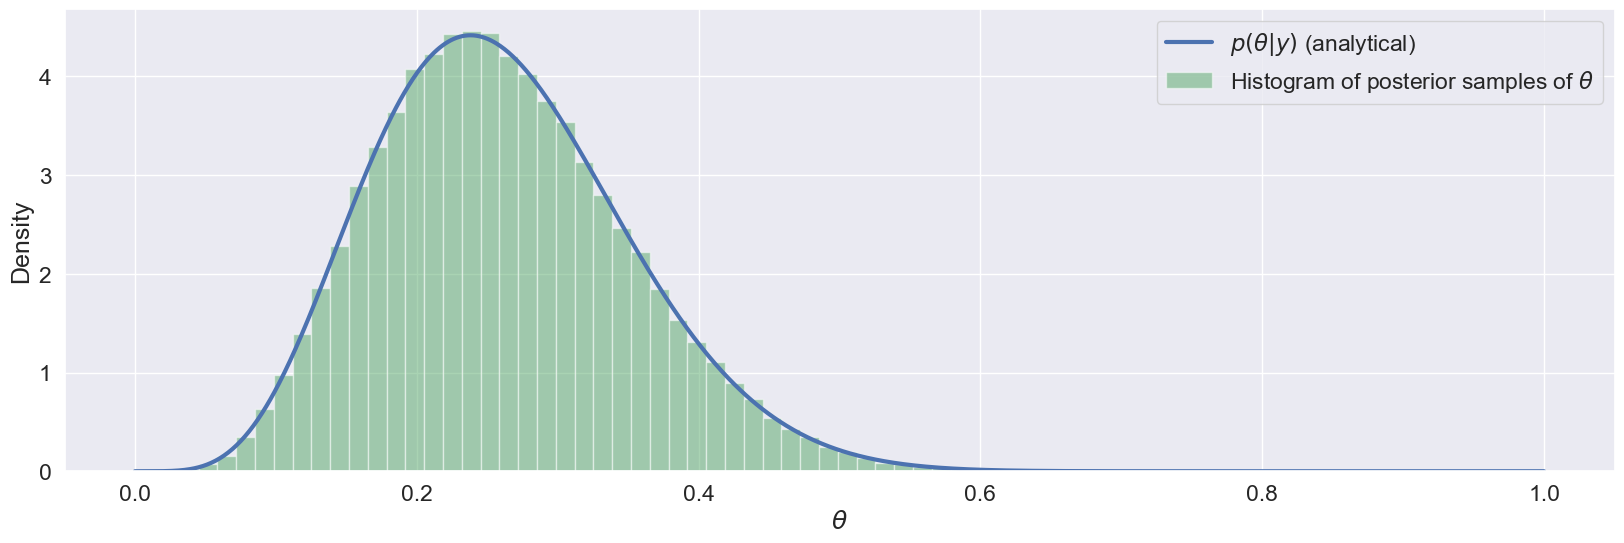

In [4]:
# Specify parameters for posterior Beta distribution
a = 6  # int, shape: scalar (posterior alpha parameter)
b = 17 # int, shape: scalar (posterior beta parameter)

# Generate samples from the posterior
num_samples = 100000  # int, shape: scalar (number of samples)
# theta_samples: np.ndarray, shape: (num_samples,)
# Each sample is drawn from Beta(a, b)
theta_samples = beta_dist.rvs(a=a, b=b, size=num_samples)

# For plotting the analytical posterior density, use a grid of theta values
# thetas_: jaxlib.xla_extension.ArrayImpl, shape: (1000, 1)
# We'll flatten it for plotting
thetas_flat = thetas.flatten()  # shape: (1000,)

# Compute the analytical Beta PDF on the grid
# beta_dist.pdf returns np.ndarray, shape: (1000,)
pdf_vals = beta_dist.pdf(thetas_flat, a=a, b=b)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Plot the analytical posterior density
# Equation: p(θ|y) = Beta(θ | a, b)
ax.plot(thetas_flat, pdf_vals, label='$p(\\theta|y)$ (analytical)', color='b')

# Plot histogram of posterior samples
# Histogram approximates the posterior density using samples
ax.hist(theta_samples, bins=50, density=True, label='Histogram of posterior samples of $\\theta$', alpha=0.5, color='g')

ax.set(xlabel='$\\theta$', ylabel='Density')
ax.legend()

# Print input and output shapes for clarity
print(f"Input: a (int, shape: scalar) = {a}")
print(f"Input: b (int, shape: scalar) = {b}")
print(f"Input: num_samples (int, shape: scalar) = {num_samples}")
print(f"Input: thetas_ (array, shape: {thetas.shape})")
print(f"Output: theta_samples (array, shape: {theta_samples.shape})")
print(f"Output: pdf_vals (array, shape: {pdf_vals.shape})")

Using the posterior samples $\theta^{(i)} \sim p(\theta|y)$ for $i = 1, \dots, S$, we can easily **estimate** the posterior mean and variance:


In [6]:
# Analytical posterior mean and variance for Beta(a, b):
#   E[theta|D] = a / (a + b)
#   Var[theta|D] = (a * b) / ((a + b)**2 * (a + b + 1))
analytical_posterior_mean = a/(a+b)  # E[theta|D] analytically
analytical_posterior_variance = (a*b)/((a+b)**2*(a+b+1))  # Var[theta|D] analytically

# Estimate the posterior mean using the samples
# This is the Monte Carlo estimate: average of the samples
print(f'E[theta|D] = {jnp.mean(theta_samples):5.4f} (estimated using samples)')

# Print the analytical posterior mean for comparison
print(f'E[theta|D] = {analytical_posterior_mean:5.4f} (analytical solution)\n')

# Estimate the posterior variance using the samples
# This is the Monte Carlo estimate: variance of the samples
print(f'V[theta|D] = {jnp.var(theta_samples):5.4f} (estimated using samples)')

# Print the analytical posterior variance for comparison
print(f'V[theta|D] = {analytical_posterior_variance:5.4f} (analytical solution)')

E[theta|D] = 0.2608 (estimated using samples)
E[theta|D] = 0.2609 (analytical solution)

V[theta|D] = 0.0080 (estimated using samples)
V[theta|D] = 0.0080 (analytical solution)


____
Sampling is often easy to implement, and hence, it can also be a highly valuable method for verifying analytical results. 

We can also estimate probabilities and credibility intervals using samples as follows. Suppose we want to estimate the posterior probability that $\theta > 0.2$, then we generate $S$ samples from the posterior, i.e. $\theta^{(i)} \sim p(\theta|\mathcal{D})$ for $i = 1, ..., S$, and then simply count the fraction of samples satisfying $\theta^{(i)} < 0.2$. The reason this works is that we can phrase  the probability as an expectation value, which can be estimated using so-called **Monte Carlo samples**:

$$\begin{align*}
P(\theta > 0.2 | \mathcal{D}) = \int_{0.2}^1 p(\theta|\mathcal{D}) \text{d} \theta = \int_0^1 \mathbb{I}\left[\theta > 0.2\right] p(\theta|\mathcal{D}) \text{d}\theta = \mathbb{E}_{p(\theta|\mathcal{D})}\left[\mathbb{I}\left[\theta > 0.2\right]\right] \approx \frac{1}{S}\sum_{i=1}^S \mathbb{I}\left[\theta^{(i)} > 0.2\right],
\end{align*}$$
where $\mathbb{I}\left[\cdot\right]$ is the indicator function yielding $1$ if the condition in the brackets are true, and 0 otherwise. We will talk much more about Monte Carlo sampling later in the course, but for now, we will simply use it as tool to summarize distributions:

In [9]:
print(f'P[theta > 0.2|D] = {jnp.mean(theta_samples > 0.2):5.4f}\t\t\t(estimated using sampling)\n')

interval = jnp.percentile(theta_samples, jnp.array([2.5, 97.5]))
print(f'95% credibility interval: [{interval[0]:4.3f}, {interval[1]:4.3f}]\t(estimated using sampling)')

P[theta > 0.2|D] = 0.7334			(estimated using sampling)

95% credibility interval: [0.107, 0.453]	(estimated using sampling)


Generally, the larger number of samples $S$ used, the more accurate an estimate we will get. Later in the course, we will make this statement much more precise.

**Example**

A friend of yours is building a classifier for a company, and she asks for your help to evaluate the model. On an independent test set of $N = 100$ examples, the classifier made $y = 8$ errors.  It is critical for the company that the error rate is below 10%. Your friend argues that the error rate is $\frac{8}{100} = 0.08$, so there no need to worry, but you are not as convinced because of the rather small test set.

Let $\theta$ represent the error rate and assume a flat Beta-prior, i.e. $a_0 = b_0 = 1$. 

**Task 4.1**: Compute the posterior mean of the error rate $\theta$.

**Solution**

The posterior distribution $p(\theta|\mathcal{D}) = \text{Beta}(\theta|a, b)$ is a Beta-distribution with parameters $a = 1 + 8 = 9$ and $b = 1 + 100 - 8 = 93$.
The posterior is therefore given by

$$\mathbb{E}\left[\theta|\mathcal{D}\right] = \frac{a}{a + b} = \frac{9}{9 + 93} = \frac{9}{102} \approx 0.09$$


**End of solution**




**Task 4.2**: Generate $S = 10000$ samples from the posterior distribution and estimate the posterior probability of the test error being larger than $10%$.  Comment on the result.

**Solution**




In [10]:
# specify parameters for posterior distribution
a = 9
b = 93

# generate samples
num_samples = 10000
theta_samples = beta_dist.rvs(a=a, b=b, size=num_samples)

# compute probability using sampling
prob = jnp.mean(theta_samples > 0.1)

# print result
print(f'P(theta > 0.1|D) = {prob:4.3f}\t\t(Estimated using sampling)')

P(theta > 0.1|D) = 0.311		(Estimated using sampling)




**End of solution**


# Part 5:  Application to A/B testing



Suppose a website has two ads: version A and version B and that version A was shown $N_A = 947$ times and generated $y_A = 87$ clicks, whereas version B was shown $N_B = 1053$ times and generated $y_B = 101$ click.

We will now put everything together and apply it do a Bayesian analysis of the data using the Beta-binomial model. 

**Task 5.1** Assuming a $\text{Beta}(\theta|2, 2)$ prior for both $\theta_A$ and $\theta_B$, plot the posterior density for both ads.

**Solution**

Input: a0 (int, shape: scalar) = 2
Input: b0 (int, shape: scalar) = 2
Input: N_A (int, shape: scalar) = 947
Input: y_A (int, shape: scalar) = 87
Input: N_B (int, shape: scalar) = 1053
Input: y_B (int, shape: scalar) = 101
Input: num_samples (int, shape: scalar) = 10000
Input: thetas (array, shape: (1000,))
Output: a_A (int, shape: scalar) = 89
Output: b_A (int, shape: scalar) = 862
Output: a_B (int, shape: scalar) = 103
Output: b_B (int, shape: scalar) = 954
Output: theta_A (array, shape: (10000,))
Output: theta_B (array, shape: (10000,))


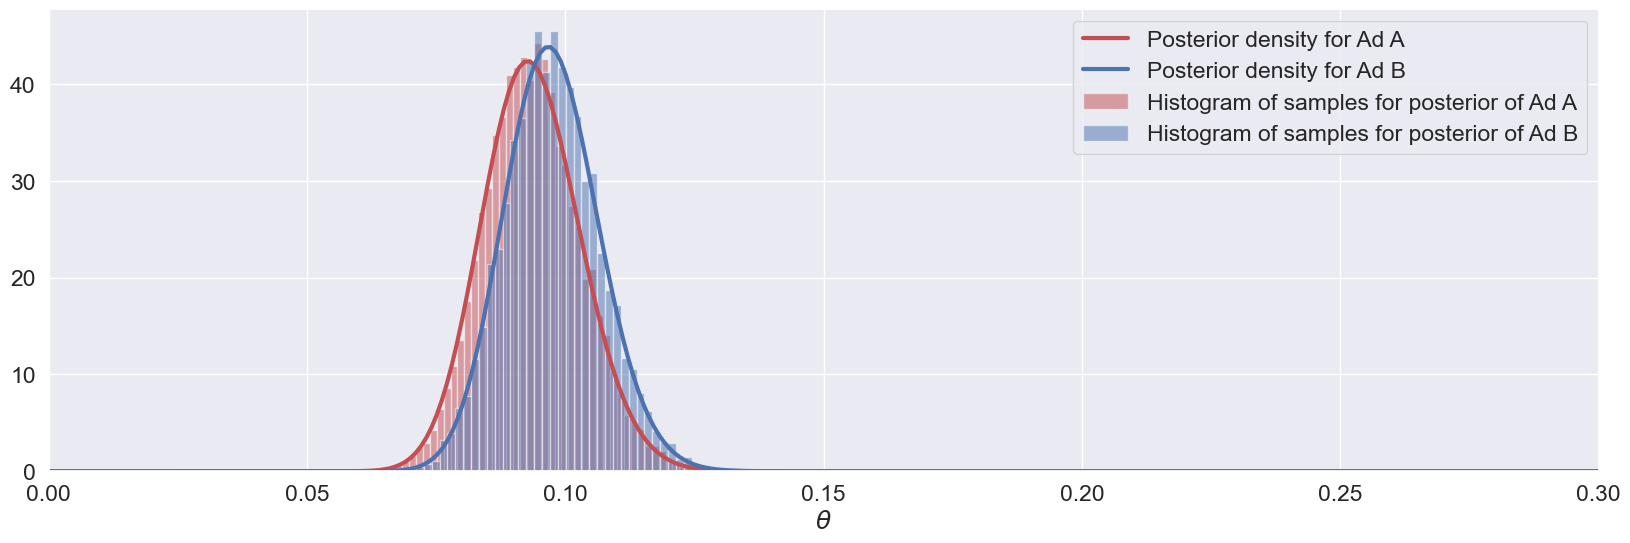

In [7]:
# Prior hyperparameters for Beta prior
# a0: int, shape: scalar (prior alpha parameter)
# b0: int, shape: scalar (prior beta parameter)
a0 = 2
b0 = 2

# Data for Ad A and Ad B
# N_A: int, shape: scalar (number of trials for Ad A)
# y_A: int, shape: scalar (number of successes for Ad A)
# N_B: int, shape: scalar (number of trials for Ad B)
# y_B: int, shape: scalar (number of successes for Ad B)
N_A, y_A = 947, 87
N_B, y_B = 1053, 101

# Posterior hyperparameters for Beta posterior
# Equations:
#   a_A = a0 + y_A
#   b_A = b0 + N_A - y_A
#   a_B = a0 + y_B
#   b_B = b0 + N_B - y_B
# a_A, b_A, a_B, b_B: int, shape: scalar
a_A, b_A = a0 + y_A, b0 + N_A - y_A
a_B, b_B = a0 + y_B, b0 + N_B - y_B

# Generate posterior samples for both ads
# num_samples: int, shape: scalar (number of samples)
num_samples = 10000
# theta_A: np.ndarray, shape: (num_samples,) (samples from Beta(a_A, b_A))
# theta_B: np.ndarray, shape: (num_samples,) (samples from Beta(a_B, b_B))
theta_A = beta_dist.rvs(a=a_A, b=b_A, size=num_samples)
theta_B = beta_dist.rvs(a=a_B, b=b_B, size=num_samples)

# For plotting the analytical posterior density, use a grid of theta values
# thetas: jaxlib.xla_extension.ArrayImpl, shape: (10000,)
# Already defined in the notebook

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Analytical posterior density for Ad A: p(θ|y_A) = Beta(θ | a_A, b_A)
ax.plot(thetas, beta_dist.pdf(thetas, a=a_A, b=b_A), color='r', label='Posterior density for Ad A')

# Analytical posterior density for Ad B: p(θ|y_B) = Beta(θ | a_B, b_B)
ax.plot(thetas, beta_dist.pdf(thetas, a=a_B, b=b_B), color='b', label='Posterior density for Ad B')

# Histogram of posterior samples for Ad A
ax.hist(theta_A, 50, color='r', label='Histogram of samples for posterior of Ad A', density=True, alpha=0.5)

# Histogram of posterior samples for Ad B
ax.hist(theta_B, 50, color='b', label='Histogram of samples for posterior of Ad B', density=True, alpha=0.5)

ax.set(xlabel='$\\theta$', xlim=(0,0.3))
ax.legend()

# Print input and output shapes for clarity
print(f"Input: a0 (int, shape: scalar) = {a0}")
print(f"Input: b0 (int, shape: scalar) = {b0}")
print(f"Input: N_A (int, shape: scalar) = {N_A}")
print(f"Input: y_A (int, shape: scalar) = {y_A}")
print(f"Input: N_B (int, shape: scalar) = {N_B}")
print(f"Input: y_B (int, shape: scalar) = {y_B}")
print(f"Input: num_samples (int, shape: scalar) = {num_samples}")
print(f"Input: thetas (array, shape: {thetas.shape})")
print(f"Output: a_A (int, shape: scalar) = {a_A}")
print(f"Output: b_A (int, shape: scalar) = {b_A}")
print(f"Output: a_B (int, shape: scalar) = {a_B}")
print(f"Output: b_B (int, shape: scalar) = {b_B}")
print(f"Output: theta_A (array, shape: {theta_A.shape})")
print(f"Output: theta_B (array, shape: {theta_B.shape})")

**End of solution**

**Task 5.2** Estimate the mean and a 95%-credibility interval for both ads. Use a $p(\theta) = \text{Beta}(\theta|2, 2)$ prior for both ads.


**Solution**

In [12]:
print(100*'*')
print('Ad A')
print(100*'*')
summarize_posterior(N=N_A, y=y_A, a0=a0, b0=b0, interval_sizes=[95])
print('\n')

print(100*'*')
print('Ad B')
print(100*'*')
summarize_posterior(N=N_B, y=y_B, a0=a0, b0=b0, interval_sizes=[95])

****************************************************************************************************
Ad A
****************************************************************************************************
Data:           87 successes in 947 trials
Prior:          Beta(2,2)
Posterior:      Beta(89, 862)
Posterior mean: 0.09
95%-credibility interval: [0.08-0.11]



****************************************************************************************************
Ad B
****************************************************************************************************
Data:           101 successes in 1053 trials
Prior:          Beta(2,2)
Posterior:      Beta(103, 954)
Posterior mean: 0.10
95%-credibility interval: [0.08-0.12]



**End of solution**

**Task 5.3** Generate $S = 10000$ posterior samples for both ads and plot the histograms of both sets of samples.

**Solution**

See code above.

**End of solution**


**Task 5.4** Compute posterior samples for the difference of $\theta_D = \theta_B - \theta_A$ and visualize the histogram

**Solution**



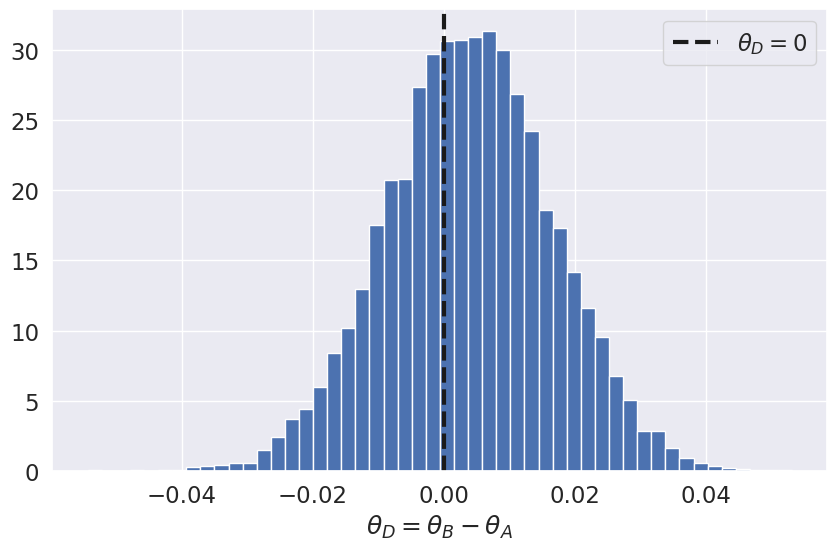

In [13]:
theta_diff = theta_B - theta_A

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(theta_diff, 50, density=True)
ax.set(xlabel='$\\theta_D = \\theta_B - \\theta_A$');
ax.axvline(0, linestyle='--', color='k', label='$\\theta_D = 0$')
ax.legend();

**End of solution**



**Task 5.5** Compute the posterior mean and 95% credibility interval for $\theta_D$ using the posterior samples

**Solution**

In [14]:
interval = jnp.percentile(theta_diff, jnp.array([2.5, 97.5]))
print(f'Posterior mean of mu_D:\t\t{jnp.mean(theta_diff):4.3f} (estimated using samples)')
print(f'95%-credibility interval:\t[{interval[0]:4.3f}, {interval[1]:4.3f}] (estimated using sampling)')

Posterior mean of mu_D:		0.004 (estimated using samples)
95%-credibility interval:	[-0.022, 0.028] (estimated using sampling)


**End of solution**

**Task 5.6** What is the posterior probability that the click-rate of version B is larger than click-rate of version A?

**Solution**

In [15]:
print(f'P(theta_B > theta_A|D) = {jnp.mean(theta_B > theta_A):4.3f} (estimated using samples)')

P(theta_B > theta_A|D) = 0.619 (estimated using samples)


**End of solution**